## In class, we applied DWNN to perform predictions over the NOAA dataset. The input space ended up having 6 dimensions, which makes it hard to visualize.

## We want a mathematical approach to detect whether the points in input space follow the shape to which DWNN is weak.

In [5]:
# We assume that each row in the dataset follows (x1, x2, ..., xN, y),
#   with y as last element
# @param dataset Must be a matrix or data.frame
# @param query Can be a single number, a vector or a matrix whose rows are query points.
# @param sigma The hyperparameter of the DWNN.
dwnn = function(dataset, query, sigma){
    dataset = as.matrix(dataset)
    if(!is.matrix(query)) # assume it is a vector
        query = as.matrix(query, nrow=1)
    
    X = as.matrix(dataset[,1:(ncol(dataset)-1)], ncol=(ncol(dataset)-1))
    Y = dataset[,ncol(dataset)]
    
    Z = apply(query, 1, function(queryRow){
        dists = apply(X, 1, function(row){
            sqrt(sum(
                (row - queryRow)**2
            ))
        })
        activations = exp(-dists**2 / (2*sigma**2))
        return( (activations %*% Y) / sum(activations) )
    })

    if(is.matrix(query))
        return(Z)
    else
        return(as.numeric(Z))
}

## Let's see if it's working

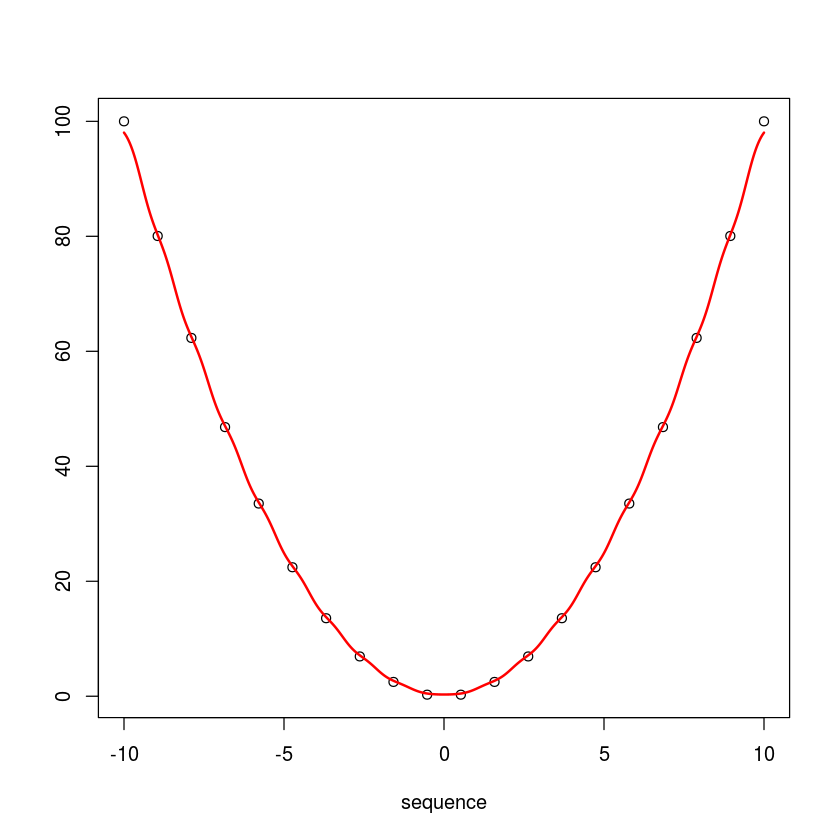

In [6]:
sequence = seq(-10, 10, length=20)
dataset = cbind(sequence, sequence**2)

x = seq(-10, 10, length=1000)
query = matrix(x, ncol=1)

result = dwnn(dataset, query, sigma = 0.5)

plot(dataset)
points(cbind(query, result), col=2, type="l", lwd=2)

## Now let's see what happens when the X in the dataset is not evenly spaced

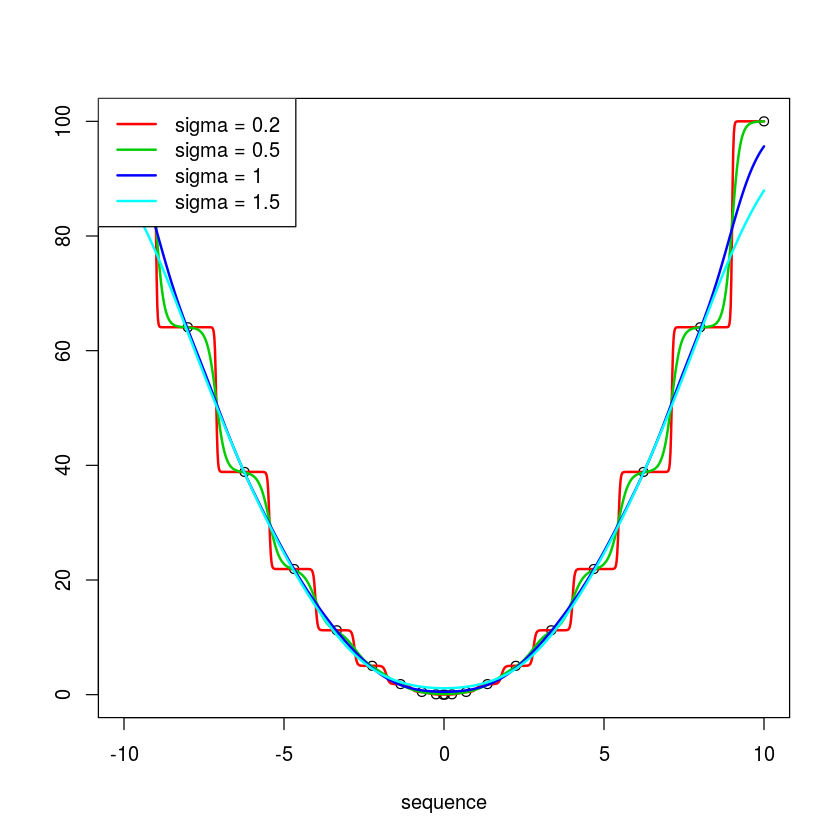

In [7]:
sequence = seq(-10, 10, length=20)
sequence = (sequence**3 / abs(sequence)) / 10
dataset = cbind(sequence, sequence**2)

x = seq(-10, 10, length=1000)
query = matrix(x, ncol=1)

plot(dataset)

allSigmas = c(0.2, 0.5, 1, 1.5)
for(i in 1:length(allSigmas)){
    result = dwnn(dataset, query, sigma = allSigmas[i])
    points(cbind(query, result), col=i+1, type="l", lwd=2)
}
legend("topleft", legend=paste("sigma =", allSigmas), col=1:length(allSigmas)+1, lwd=2)

## The biggest problem is actually when the new point x is far from the other points

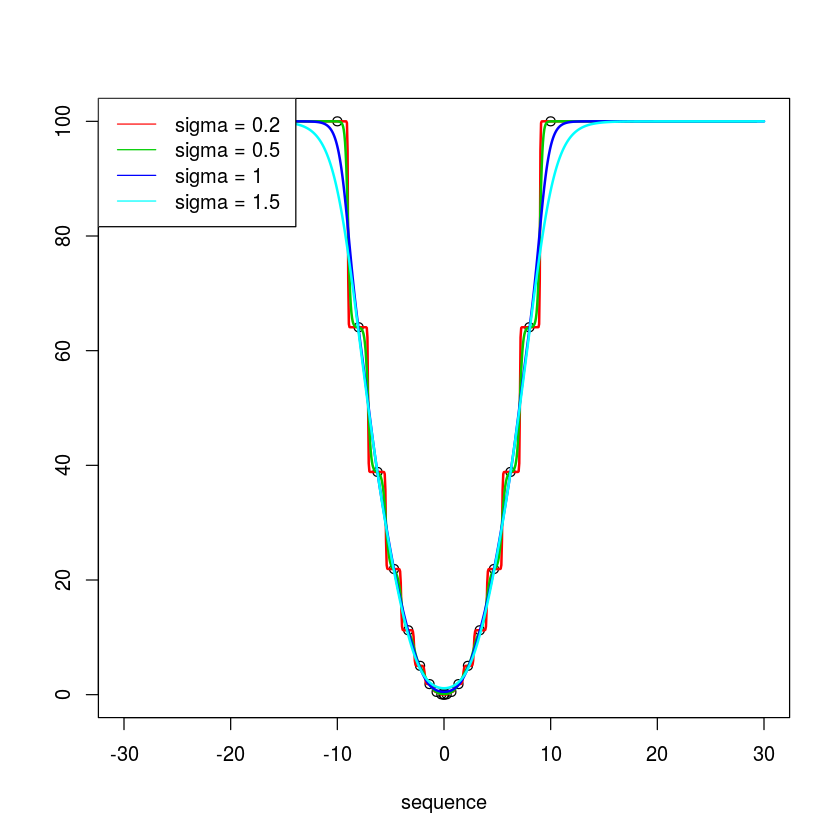

In [8]:
sequence = seq(-10, 10, length=20)
sequence = (sequence**3 / abs(sequence)) / 10
dataset = cbind(sequence, sequence**2)

x = seq(-30, 30, length=1000)
query = matrix(x, ncol=1)

plot(dataset, xlim = c(-30, 30))

allSigmas = c(0.2, 0.5, 1, 1.5)
for(i in 1:length(allSigmas)){
    result = dwnn(dataset, query, sigma = allSigmas[i])
    points(cbind(query, result), col=i+1, type="l", lwd=2)
}
legend("topleft", legend=paste("sigma =", allSigmas), col=1:length(allSigmas)+1, lwd=1)

## We could say that the prediction is "bad" when the new point $\hat{x}$ is not "surrounded" by other points from the dataset.

## How can we detect "surroundedness"?

## We thought of taking all difference vectors

$$
    v_i = \hat{x} - x_i
$$

## And then calculating the angle between each of these vectors, using the formula

$$
    cos(\theta) = \frac{<v_i, v_j>}{||v_i|| \;||v_j||}
$$

## Then we expect that the variance of all cosines is low whenever the points is not "surrounded" by other points.

## Let's test this for the example used above.

In [42]:
sequence = seq(-10, 10, length=20)
sequence = (sequence**3 / abs(sequence)) / 10
dataset = cbind(sequence, sequence**2)

x = seq(-30, 30, length=100)
query = matrix(x, ncol=1)

# Returns the norm2 of each line in matrix v1
norm2 = function(v1){
    if(!is.matrix(v1))
        v1 = matrix(v1, ncol=length(v1))
    
    return(sqrt(
        apply(v1, 1, function(row) sum(row**2))
    ))
}

# Returns the cosine between each pair of rows from v1 and v2
cosine = function(v1, v2){
    if(!is.matrix(v1))
        v1 = as.matrix(v1, ncol=length(v1))    
    if(!is.matrix(v2))
        v2 = as.matrix(v2, ncol=length(v2))

    v2norms = norm2(v2)

    return(
        apply(v1, 1, function(v1row){
            aux = t(v1row) %*% t(v2)
            return( as.numeric(aux / (norm2(v1row) * v2norms)) )
        })
    )
}

#apply(query, 1, function(queryRow){
#    cosines = apply(dataset, 1, function(row){
#        cosine(queryRow, row[1])
#    })
#    print(cosines)
#    return(var(cosines))
#})
q = query[55,]
print(q)
diffs = q - dataset[,1]
cosines = cosine(diffs, diffs)
cosines = cosines[upper.tri(cosines)]
cat("Mean: ", mean(cosines), "\n")
cat("Variance: ", sd(cosines), "\n")
           
q = query[20,]
print(q)
diffs = q - dataset[,1]
cosines = cosine(diffs, diffs)
cosines = cosines[upper.tri(cosines)]
cat("Mean: ", mean(cosines), "\n")
cat("Variance: ", sd(cosines), "\n")
           
q = query[90,]
print(q)
diffs = q - dataset[,1]
cosines = cosine(diffs, diffs)
cosines = cosines[upper.tri(cosines)]
cat("Mean: ", mean(cosines), "\n")
cat("Variance: ", sd(cosines), "\n")

[1] 2.727273
Mean:  0.2105263 
Variance:  0.980171 
[1] -18.48485
Mean:  1 
Variance:  0 
[1] 23.93939
Mean:  1 
Variance:  0 


## That gives a lot of hope!

## We must put this to work into a better benchmark, though.

## Let's try datasets with a form such as an N-dimensional sphere with radius 1; then a point (1.5, ..., 1.5) should be deemed as "not surrounded", whereas (0.5, ..., 0.5) as "surrounded".

In [231]:
spherical_dataset = function(dim=3, rows=1000){
    result = matrix(rnorm(n=dim*rows, mean=0, sd=1), ncol=dim, nrow=rows)
    result[result > 1] = 1
    result[result < -1] = -1
    return(result)
}

hypercubic_dataset = function(dim=3, rows=1000){
    result = matrix(runif(n=dim*rows, min=-1, max=1), ncol=dim, nrow=rows)
    result[result > 1] = 1
    result[result < -1] = -1
    return(result)
}

test.cosines = function(dims=c(3, 6, 9, 12), dataset_func=spherical_dataset){
    get.var.mean = function(query, dataset){
        diff = query - dataset
        cos = cosine(diff, diff)
        cos = cos[upper.tri(cos)]
        cos[is.na(cos)] = 0 # We define cosine of (0, 0, 0) with (0, 0, 0) as 0
        return( c(var(cos), mean(cos)) )
    }
    
    for(dim in dims){
        cat("Dimension: ", dim, "\n")
        
        dataset = dataset_func(dim=dim, rows=5**3)
        badQuery = rep(1.5, dim)
        avgQuery = rep(1.0, dim)
        goodQuery = rep(0.5, dim)
        
        stats = get.var.mean(badQuery, dataset)
        cat("\tBad query:  variance = ", stats[1], " mean = ", stats[2], "\n")
        
        stats = get.var.mean(-badQuery, dataset)
        cat("\t-Bad query: variance = ", stats[1], " mean = ", stats[2], "\n")

        stats = get.var.mean(avgQuery, dataset)
        cat("\tAvg query:  variance = ", stats[1], " mean = ", stats[2], "\n")
        
        stats = get.var.mean(goodQuery, dataset)
        cat("\tGood query: variance = ", stats[1], " mean = ", stats[2], "\n")
    }
}

cat("Spherical\n\n")
test.cosines(dataset_func=spherical_dataset)
cat("\n\nHypercubic\n\n")
test.cosines(dataset_func=hypercubic_dataset)

Spherical

Dimension:  3 
	Bad query:  variance =  0.01452758  mean =  0.8566529 
	-Bad query: variance =  0.01428058  mean =  0.8589666 
	Avg query:  variance =  0.0592922  mean =  0.7002359 
	Good query: variance =  0.2770241  mean =  0.2649876 
Dimension:  6 
	Bad query:  variance =  0.007310061  mean =  0.8422456 
	-Bad query: variance =  0.007967883  mean =  0.8370809 
	Avg query:  variance =  0.02861595  mean =  0.6889455 
	Good query: variance =  0.1261994  mean =  0.3106319 
Dimension:  9 
	Bad query:  variance =  0.005465166  mean =  0.8254253 
	-Bad query: variance =  0.005210824  mean =  0.828181 
	Avg query:  variance =  0.02045604  mean =  0.6660799 
	Good query: variance =  0.07965988  mean =  0.3036663 
Dimension:  12 
	Bad query:  variance =  0.004353856  mean =  0.8213563 
	-Bad query: variance =  0.003989592  mean =  0.8234786 
	Avg query:  variance =  0.01590469  mean =  0.664266 
	Good query: variance =  0.05880467  mean =  0.3169683 


Hypercubic

Dimension:  3 
	B

## Good thing 1: The mean is nearer to 0 when the point is "surrounded"

## Good thing 2: The variance is higher when the point is "surrounded"

## Bad thing 1: The scale for the variance differs when the dimension increases

## Another way of checking if a point is surrounded is to see whether the point is inside the polytope defined by all the points of the dataset. This is not trivial, as it involves finding the convex hull formed by the points.

## Let's now see whether the NOAA dataset is fine or not

In [2]:
require(tseriesChaos)
require(EMD)
require(rgl)

In [3]:
# Reading Paris.csv
data = read.csv("Paris.csv")
id = which(data[,"NAME"] == "ORLY, FR")
tmax = data[id, "TMAX"]
tmax = tmax[2600:(2600 + 25345 - 1)]

# Embedding
res = emd(tmax, boundary="wave")
stochastic = rowSums(res$imf[,1:3])
deterministic = rowSums(res$imf[,4:res$nimf]) + res$residue
emb = embedd(deterministic, m=7, d=74)

In [12]:
# We will check from here
begin = nrow(emb) - 200

# We don't have enough memory, so we define another function to get cosines
cosine2 = function(diff){
    allCosines = rep(0, nrow(diff)-1)
    
    for(i in 2:nrow(diff)){
        v1 = diff[i-1,]
        v2 = diff[i,]
        allCosines[i-1] = (v1 %*% v2) / (norm2(v1) * norm2(v2))
    }
    return(allCosines)
}

df = NULL

for(i in begin:nrow(emb)){
    # x_1 x_3 x_5
    # x_2 x_4 x_6
    # x_3 x_5 x_7
    #
    # We always use the first 1:(length-1) to predict the next
    # So we have to check 1:(length-1) against the rest of the dataset
    query = emb[i,1:(ncol(emb)-1)]
    diff = query - emb[1:(i-1),1:(ncol(emb)-1)]
    cos = cosine2(diff)
    s = sd(cos)
    m = mean(cos)
#   message(paste(paste("sd = ", s, "    mean = ", m)))
    df = rbind(df, c(s, m))
}

colnames(df) = c("StdDev", "Mean")
df

StdDev,Mean
0.3675935,0.4908984
0.3022352,0.3872647
0.3859033,0.5009938
0.3161244,0.3861704
0.3779211,0.4947927
0.2659067,0.5185963
0.3761803,0.5161072
0.2863184,0.4387992
0.3957654,0.5911794
0.3059495,0.4579989


In [14]:
summary(df)

     StdDev             Mean       
 Min.   :0.07721   Min.   :0.3862  
 1st Qu.:0.21285   1st Qu.:0.5735  
 Median :0.28251   Median :0.6424  
 Mean   :0.26753   Mean   :0.6233  
 3rd Qu.:0.32495   3rd Qu.:0.6914  
 Max.   :0.44754   Max.   :0.7497  

## Instead of taking cosines from all other points, what if we considered just the nearest ones?

In [43]:
df = NULL

sigma = 4.763158 # Sigma we used in class

for(i in begin:nrow(emb)){
    query = emb[i,1:(ncol(emb)-1)]
    trainSet = emb[1:(i-1),]
    
    # Get the activations (the same used in dwnn)
    dists = apply(trainSet, 1, function(row){
        sqrt(sum(row[1:(length(row)-1)] - query)**2)
    })
    activations = exp(-dists**2 / (2*sigma**2))
    
    # Normalize activations
    activations = activations / sum(activations)

    idx = sort.list(activations, decreasing=TRUE)
    activations = activations[idx]
    trainSet = trainSet[idx,]
    
    # We want to get the points that make their cumulative activations > 90%
    acc = cumsum(activations)
    id = which(acc > 0.9)[1]
    
    trainSet = trainSet[1:id,]

    diff = query - trainSet[,1:(ncol(trainSet)-1)]
    cos = cosine(diff, diff)
    s = sd(cos)
    m = mean(cos)
    #message(paste(paste("cutoff = ", id / (i-1), "    sd = ", s, "    mean = ", m)))
    df = rbind(df, c(id / (i-1), s, m))
}

colnames(df) = c("Cutoff", "StdDev", "Mean")
df

Cutoff,StdDev,Mean
0.2693522,0.4950205,0.05253066
0.2557386,0.4937734,0.06418423
0.2396162,0.4835024,0.09528039
0.2231308,0.4829409,0.11494522
0.2096826,0.4811778,0.12764560
0.1998786,0.5469365,0.14861602
0.1937586,0.4910289,0.12183354
0.1910795,0.4905622,0.12736336
0.1917193,0.4713498,0.14530100
0.1956777,0.4946072,0.12496132


In [44]:
summary(df)

     Cutoff            StdDev            Mean        
 Min.   :0.01602   Min.   :0.4123   Min.   :0.02124  
 1st Qu.:0.07233   1st Qu.:0.4735   1st Qu.:0.12765  
 Median :0.14413   Median :0.5070   Median :0.17037  
 Mean   :0.14147   Mean   :0.5059   Mean   :0.16873  
 3rd Qu.:0.19793   3rd Qu.:0.5405   3rd Qu.:0.21547  
 Max.   :0.29514   Max.   :0.5870   Max.   :0.30537  